In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

#%load_ext autoreload
#%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

In [3]:
import IPython.display as ipd

In [4]:
def all_exp(alpha, beta, tau, temp, mixtures, model_name, data_size="search"):
    ipd.display(ipd.Markdown("**Simple SWS**"))
    model_sws, gmp_sws, res_sws = retrain_model(alpha, beta, tau, int(0), mixtures, model_name, data_size, "", False)
    show_sws_weights(model = model_sws, means = list(gmp_sws.means.data.clone().cpu()), precisions = list(gmp_sws.gammas.data.clone().cpu()))
    
    ipd.display(ipd.Markdown("**SWS KD**"))
    model_kd, gmp_kd, res_kd = retrain_model(alpha, beta, tau, temp, mixtures, model_name, data_size, "", False)
    show_sws_weights(model = model_kd, means = list(gmp_kd.means.data.clone().cpu()), precisions = list(gmp_kd.gammas.data.clone().cpu()))
    
    ipd.display(ipd.Markdown("**SWS KD Scaling**"))
    model_kd_s, gmp_kd_s, res_kd_s = retrain_model(alpha, beta, tau, temp, mixtures, model_name, data_size, "", True)
    show_sws_weights(model = model_kd_s, means = list(gmp_kd_s.means.data.clone().cpu()), precisions = list(gmp_kd_s.gammas.data.clone().cpu()))
    
    title = "Temp: {} Tau: {}\n".format(temp, tau)
    sws_res = "Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n".format(res_sws['compress_test'], res_sws['compress_val'], res_sws['prune_test'], res_sws['prune_val'], res_sws['sparsity'])
    kd_res = 'Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n'.format(res_kd['compress_test'], res_kd['compress_val'], res_kd['prune_test'], res_kd['prune_val'], res_kd['sparsity'])
    kd_s_res = 'Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n\n'.format(res_kd_s['compress_test'], res_kd_s['compress_val'], res_kd_s['prune_test'], res_kd_s['prune_val'], res_kd_s['sparsity'])
    res_str = title + sws_res + kd_res + kd_s_res
    print (res_str)
    
    return model_sws, gmp_sws, model_kd, gmp_kd, model_kd_s, gmp_kd_s, res_str

### Load good hyperparameters

In [5]:
with open("../search/sobol_search.p", "rb") as handle:
    params = pickle.load(handle)
i = 240
print ("exp:{} mean: {}, var: {}, tau: {}, temp: {}, mixtures: {}".format(i, params['mean'][i], params['var'][i], params['tau'][i], params['temp'][i], int(params['mixtures'][i])))
mean = float(params['mean'][i])
var = float(params['var'][i])
tau = float(params['tau'][i])
mixtures = int(params['mixtures'][i])
temp = float(params['temp'][i])
model_name = 'LeNet_300_100'
data_size = 'search'

exp:240 mean: 0.10181517217181825, var: 0.1034304555503225, tau: 6.479230606842127e-07, temp: 19.0, mixtures: 9


### Override Parameters

In [6]:
mixtures = 15
temp = 4
mean = 10
var = 10
beta = mean/var
alpha = mean * beta

**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.24
Epoch: 20. Test Accuracy: 97.36
Epoch: 30. Test Accuracy: 97.54
Epoch: 40. Test Accuracy: 97.69
Epoch: 50. Test Accuracy: 97.59
Retrain Test: 97.59, Retrain Validation: 0.00, Prune Test: 96.66, Prune Validation: 0.00, Prune Sparsity: 98.25


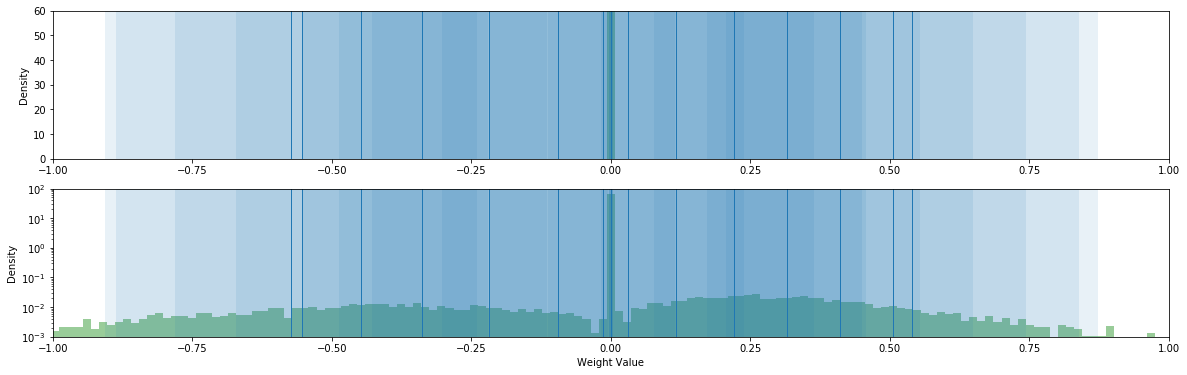

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.83
Epoch: 20. Test Accuracy: 98.12
Epoch: 30. Test Accuracy: 98.03
Epoch: 40. Test Accuracy: 98.03
Epoch: 50. Test Accuracy: 97.97
Retrain Test: 97.97, Retrain Validation: 0.00, Prune Test: 97.16, Prune Validation: 0.00, Prune Sparsity: 97.33


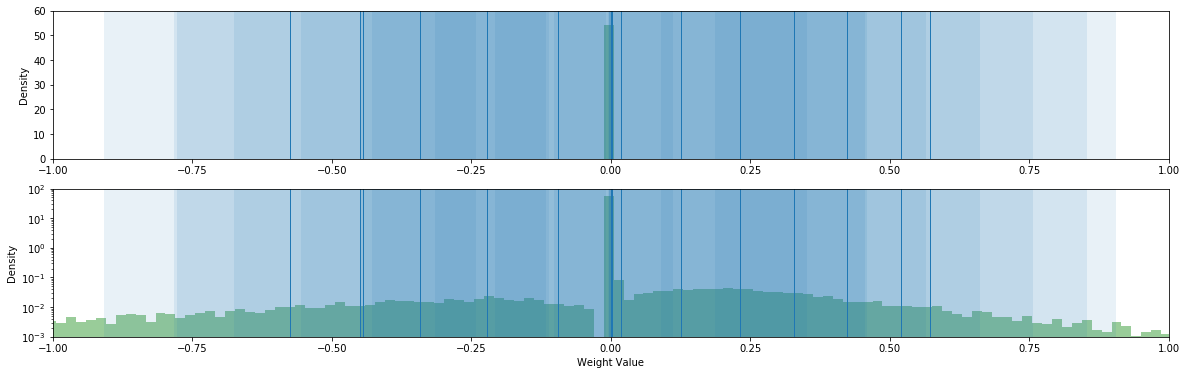

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.49
Epoch: 20. Test Accuracy: 98.08
Epoch: 30. Test Accuracy: 98.10
Epoch: 40. Test Accuracy: 98.02
Epoch: 50. Test Accuracy: 98.07
Retrain Test: 98.07, Retrain Validation: 0.00, Prune Test: 97.49, Prune Validation: 0.00, Prune Sparsity: 97.20


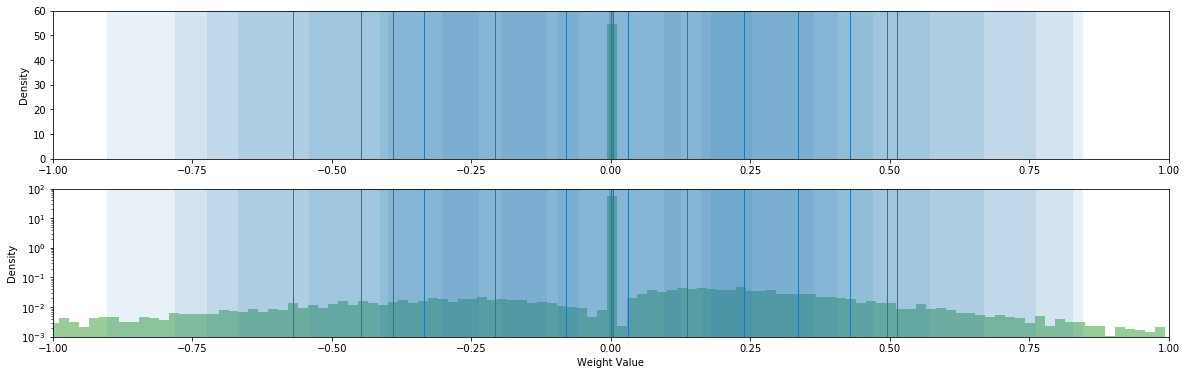

Mean: 10.0 Var: 10.0
Retrain Test: 97.59, Retrain Validation: 0.00, Prune Test: 96.66, Prune Validation: 0.00, Prune Sparsity: 98.25
Retrain Test: 97.97, Retrain Validation: 0.00, Prune Test: 97.16, Prune Validation: 0.00, Prune Sparsity: 97.33
Retrain Test: 98.07, Retrain Validation: 0.00, Prune Test: 97.49, Prune Validation: 0.00, Prune Sparsity: 97.20




<IPython.core.display.Javascript object>

In [11]:
%%notify
_, _, _, _, _, _, res = all_exp(alpha, beta, tau, temp, mixtures, model_name, data_size = 'full')

**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.90
Epoch: 20. Test Accuracy: 97.32
Epoch: 30. Test Accuracy: 96.63
Epoch: 40. Test Accuracy: 95.70
Epoch: 50. Test Accuracy: 95.90
Retrain Test: 95.90, Retrain Validation: 95.81, Prune Test: 91.75, Prune Validation: 91.90, Prune Sparsity: 98.94


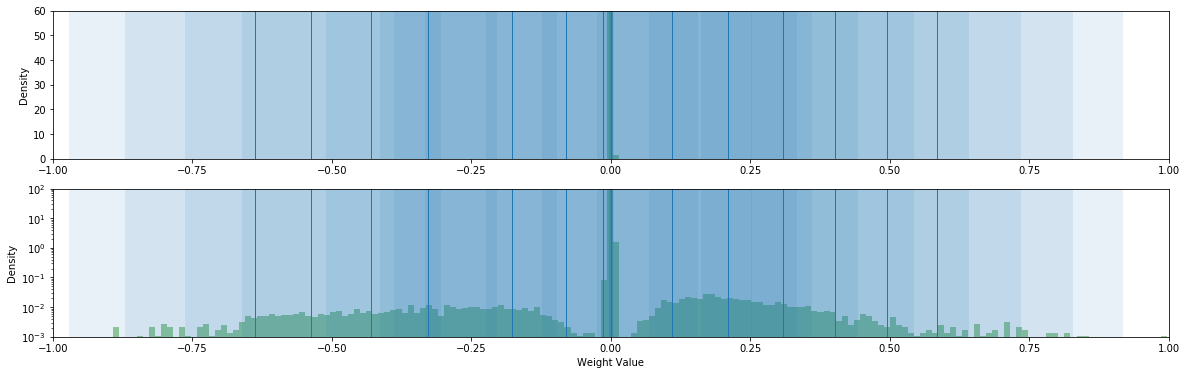

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.55
Epoch: 20. Test Accuracy: 94.80
Epoch: 30. Test Accuracy: 91.14
Epoch: 40. Test Accuracy: 89.09
Epoch: 50. Test Accuracy: 89.52
Retrain Test: 89.52, Retrain Validation: 89.58, Prune Test: 38.02, Prune Validation: 39.63, Prune Sparsity: 99.77


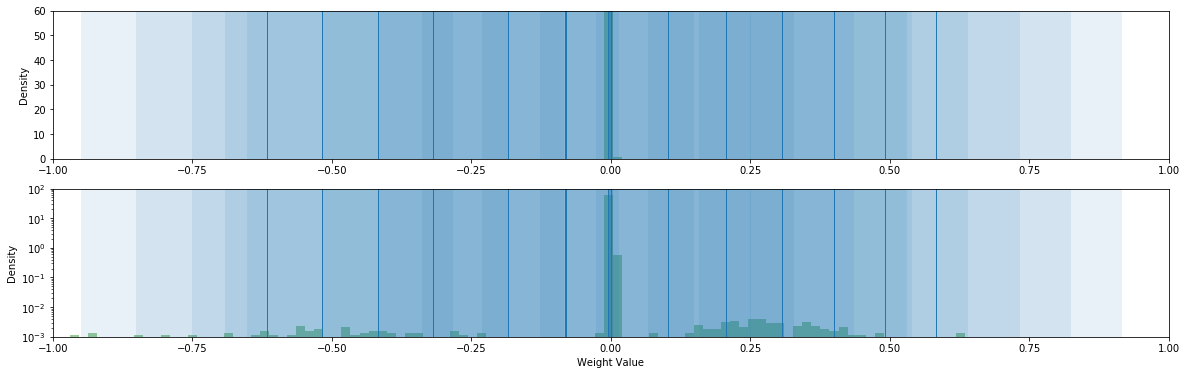

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.48
Epoch: 20. Test Accuracy: 95.28
Epoch: 30. Test Accuracy: 91.20
Epoch: 40. Test Accuracy: 89.55
Epoch: 50. Test Accuracy: 89.77
Retrain Test: 89.77, Retrain Validation: 90.49, Prune Test: 52.40, Prune Validation: 54.63, Prune Sparsity: 99.75


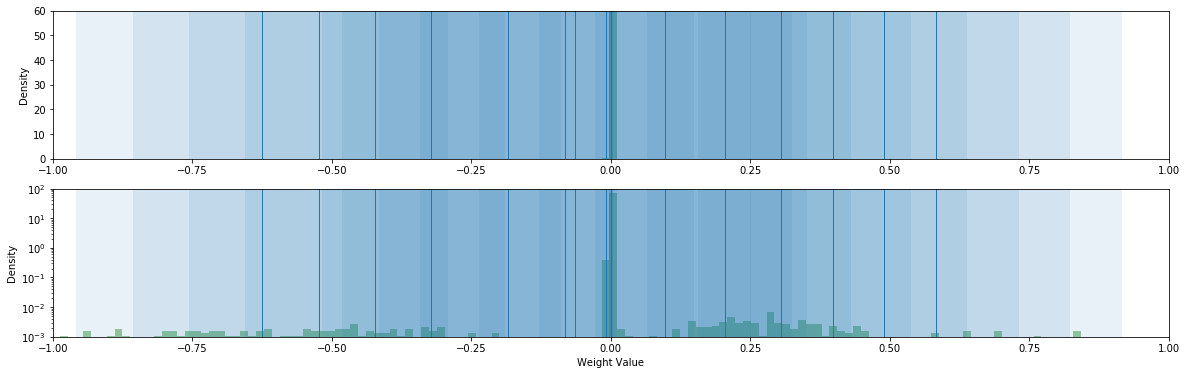

Temp: 1 Tau: 1e-06
Retrain Test: 95.90, Retrain Validation: 95.81, Prune Test: 91.75, Prune Validation: 91.90, Prune Sparsity: 98.94
Retrain Test: 89.52, Retrain Validation: 89.58, Prune Test: 38.02, Prune Validation: 39.63, Prune Sparsity: 99.77
Retrain Test: 89.77, Retrain Validation: 90.49, Prune Test: 52.40, Prune Validation: 54.63, Prune Sparsity: 99.75




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.81
Epoch: 20. Test Accuracy: 98.07
Epoch: 30. Test Accuracy: 97.93
Epoch: 40. Test Accuracy: 97.93
Epoch: 50. Test Accuracy: 97.64
Retrain Test: 97.64, Retrain Validation: 97.56, Prune Test: 91.25, Prune Validation: 90.93, Prune Sparsity: 94.26


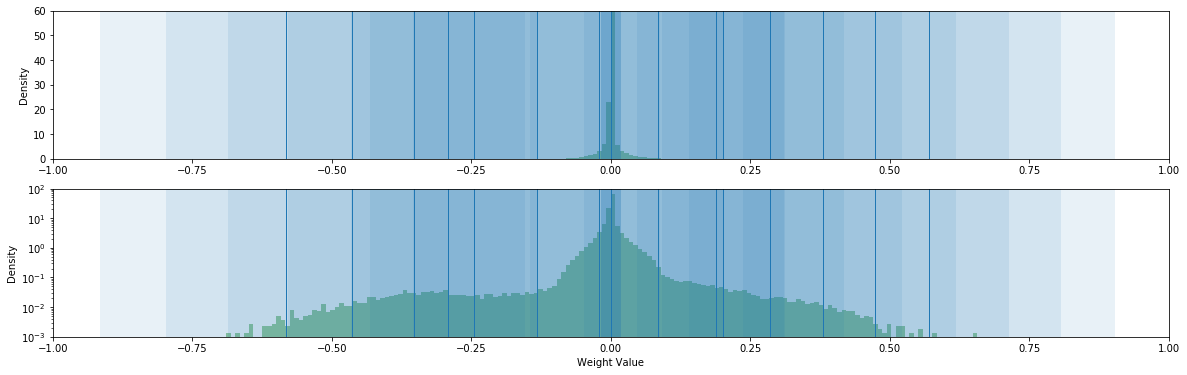

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.13
Epoch: 20. Test Accuracy: 97.83
Epoch: 30. Test Accuracy: 96.73
Epoch: 40. Test Accuracy: 96.27
Epoch: 50. Test Accuracy: 96.28
Retrain Test: 96.28, Retrain Validation: 95.96, Prune Test: 92.46, Prune Validation: 92.69, Prune Sparsity: 98.78


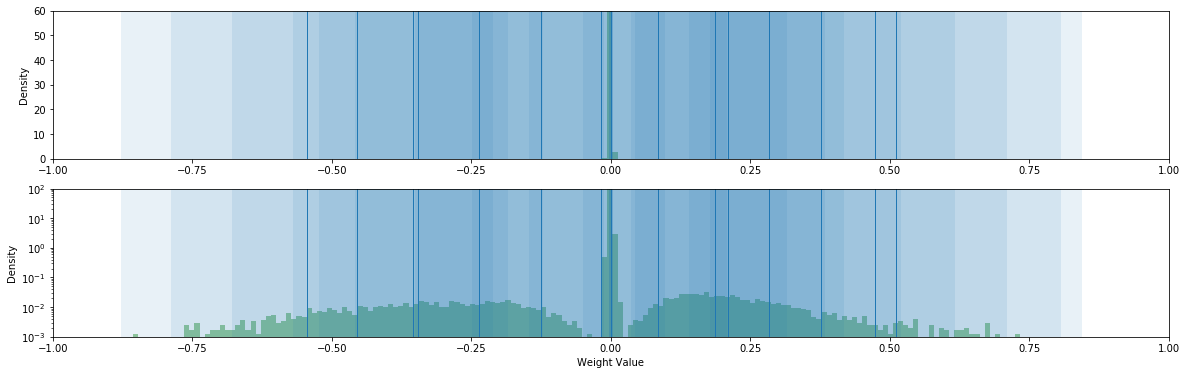

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.53
Epoch: 20. Test Accuracy: 97.71
Epoch: 30. Test Accuracy: 96.92
Epoch: 40. Test Accuracy: 96.15
Epoch: 50. Test Accuracy: 96.24
Retrain Test: 96.24, Retrain Validation: 95.86, Prune Test: 89.43, Prune Validation: 89.19, Prune Sparsity: 98.91


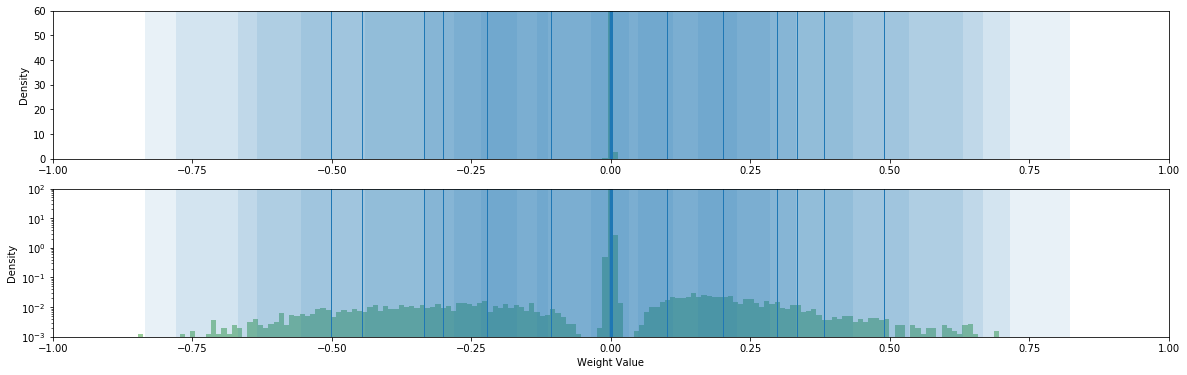

Temp: 1 Tau: 1e-07
Retrain Test: 97.64, Retrain Validation: 97.56, Prune Test: 91.25, Prune Validation: 90.93, Prune Sparsity: 94.26
Retrain Test: 96.28, Retrain Validation: 95.96, Prune Test: 92.46, Prune Validation: 92.69, Prune Sparsity: 98.78
Retrain Test: 96.24, Retrain Validation: 95.86, Prune Test: 89.43, Prune Validation: 89.19, Prune Sparsity: 98.91




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.98
Epoch: 20. Test Accuracy: 97.50
Epoch: 30. Test Accuracy: 97.73
Epoch: 40. Test Accuracy: 97.77
Epoch: 50. Test Accuracy: 97.79
Retrain Test: 97.79, Retrain Validation: 97.89, Prune Test: 97.78, Prune Validation: 97.72, Prune Sparsity: 62.79


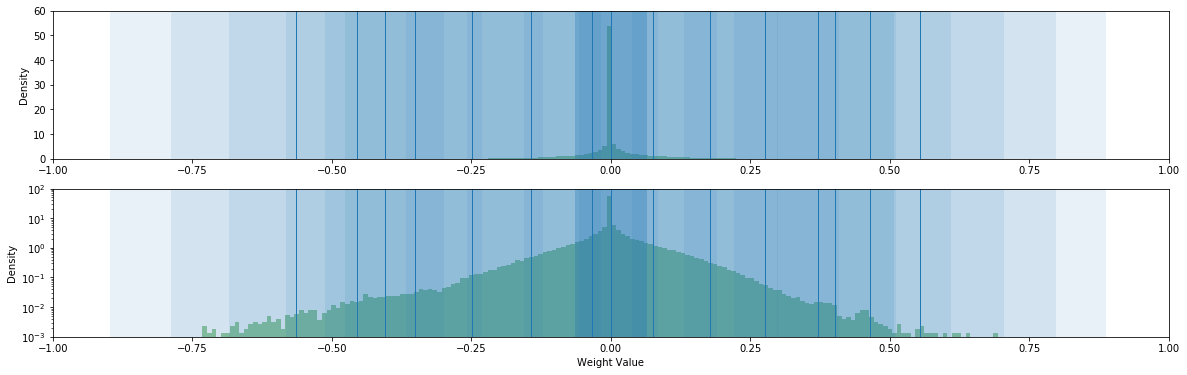

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.06
Epoch: 20. Test Accuracy: 98.04
Epoch: 30. Test Accuracy: 97.89
Epoch: 40. Test Accuracy: 98.04
Epoch: 50. Test Accuracy: 97.86
Retrain Test: 97.86, Retrain Validation: 97.87, Prune Test: 97.55, Prune Validation: 97.46, Prune Sparsity: 83.54


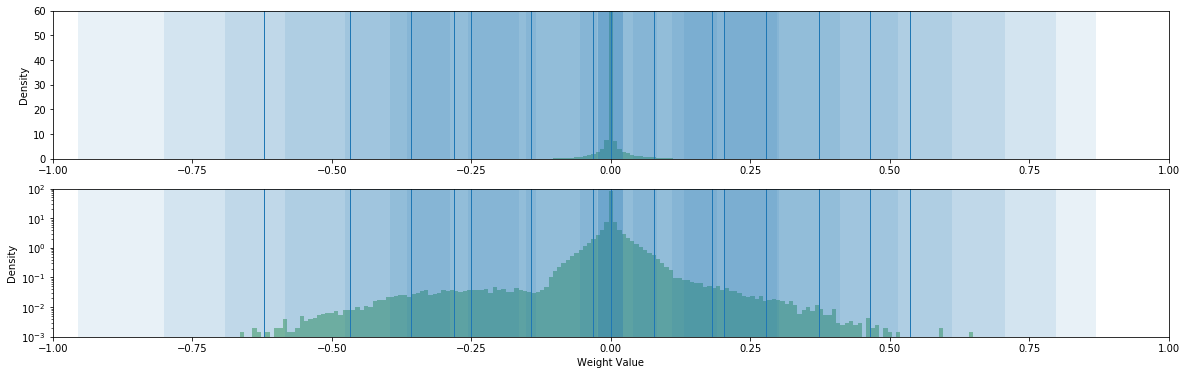

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.99
Epoch: 20. Test Accuracy: 97.99
Epoch: 30. Test Accuracy: 98.07
Epoch: 40. Test Accuracy: 98.14
Epoch: 50. Test Accuracy: 97.90
Retrain Test: 97.90, Retrain Validation: 97.75, Prune Test: 90.94, Prune Validation: 91.21, Prune Sparsity: 92.12


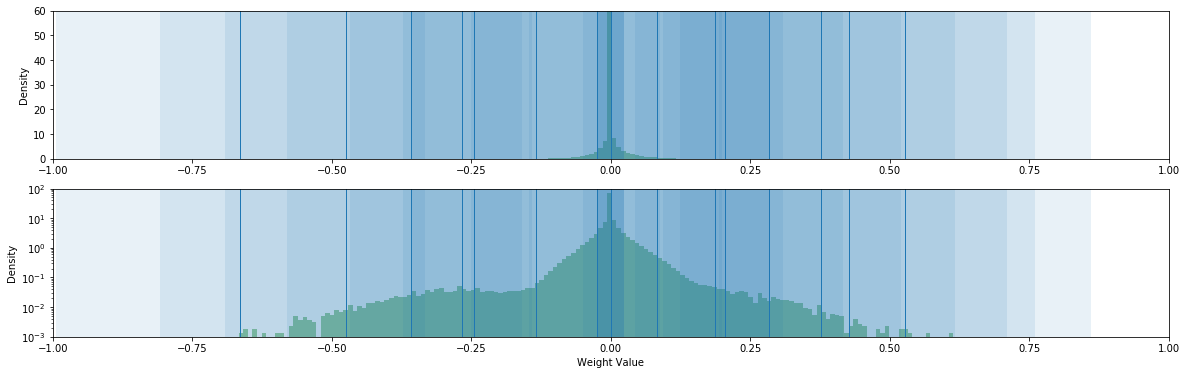

Temp: 1 Tau: 1e-08
Retrain Test: 97.79, Retrain Validation: 97.89, Prune Test: 97.78, Prune Validation: 97.72, Prune Sparsity: 62.79
Retrain Test: 97.86, Retrain Validation: 97.87, Prune Test: 97.55, Prune Validation: 97.46, Prune Sparsity: 83.54
Retrain Test: 97.90, Retrain Validation: 97.75, Prune Test: 90.94, Prune Validation: 91.21, Prune Sparsity: 92.12




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.04
Epoch: 20. Test Accuracy: 97.59
Epoch: 30. Test Accuracy: 96.77
Epoch: 40. Test Accuracy: 95.99
Epoch: 50. Test Accuracy: 95.81
Retrain Test: 95.81, Retrain Validation: 96.06, Prune Test: 91.06, Prune Validation: 91.35, Prune Sparsity: 98.91


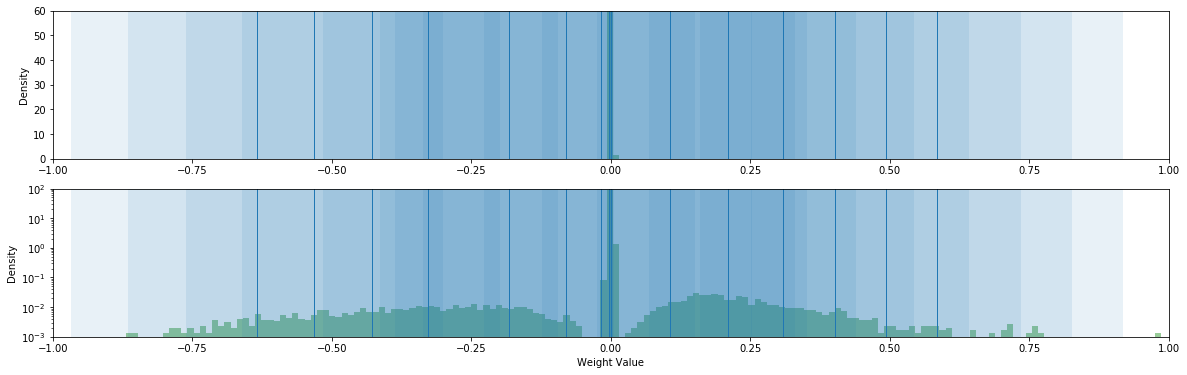

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.93
Epoch: 20. Test Accuracy: 97.08
Epoch: 30. Test Accuracy: 95.27
Epoch: 40. Test Accuracy: 93.91
Epoch: 50. Test Accuracy: 94.18
Retrain Test: 94.18, Retrain Validation: 94.42, Prune Test: 83.30, Prune Validation: 84.14, Prune Sparsity: 99.37


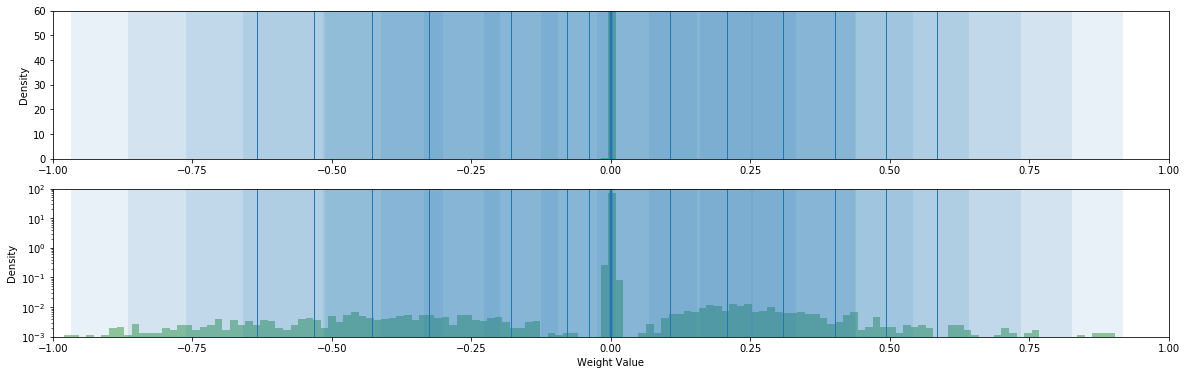

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.75
Epoch: 20. Test Accuracy: 97.07
Epoch: 30. Test Accuracy: 95.33
Epoch: 40. Test Accuracy: 94.22
Epoch: 50. Test Accuracy: 94.71
Retrain Test: 94.71, Retrain Validation: 94.63, Prune Test: 86.27, Prune Validation: 87.45, Prune Sparsity: 99.33


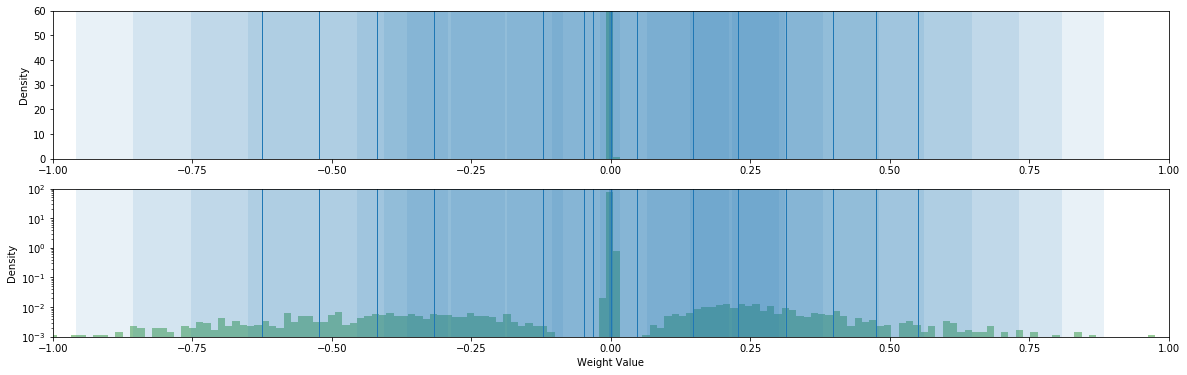

Temp: 2 Tau: 1e-06
Retrain Test: 95.81, Retrain Validation: 96.06, Prune Test: 91.06, Prune Validation: 91.35, Prune Sparsity: 98.91
Retrain Test: 94.18, Retrain Validation: 94.42, Prune Test: 83.30, Prune Validation: 84.14, Prune Sparsity: 99.37
Retrain Test: 94.71, Retrain Validation: 94.63, Prune Test: 86.27, Prune Validation: 87.45, Prune Sparsity: 99.33




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.05
Epoch: 20. Test Accuracy: 98.18
Epoch: 30. Test Accuracy: 97.97
Epoch: 40. Test Accuracy: 97.95
Epoch: 50. Test Accuracy: 97.76
Retrain Test: 97.76, Retrain Validation: 97.66, Prune Test: 91.93, Prune Validation: 91.63, Prune Sparsity: 93.70


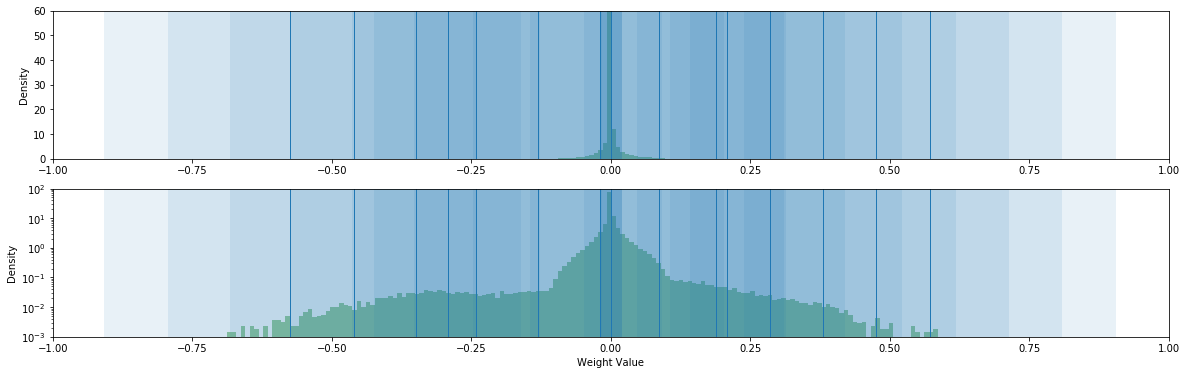

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.01
Epoch: 20. Test Accuracy: 98.09
Epoch: 30. Test Accuracy: 97.73
Epoch: 40. Test Accuracy: 96.96
Epoch: 50. Test Accuracy: 96.87
Retrain Test: 96.87, Retrain Validation: 96.95, Prune Test: 96.32, Prune Validation: 96.18, Prune Sparsity: 97.53


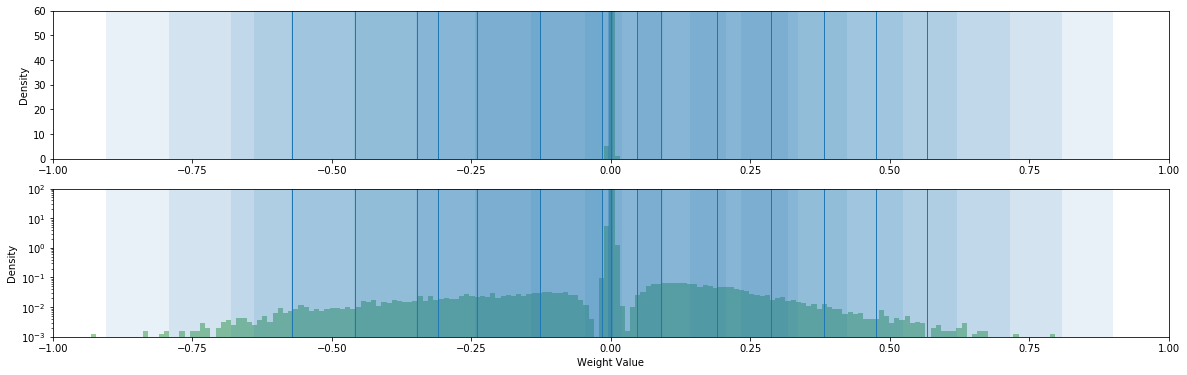

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.06
Epoch: 20. Test Accuracy: 97.92
Epoch: 30. Test Accuracy: 97.76
Epoch: 40. Test Accuracy: 97.50
Epoch: 50. Test Accuracy: 97.06
Retrain Test: 97.06, Retrain Validation: 96.98, Prune Test: 96.26, Prune Validation: 96.02, Prune Sparsity: 97.18


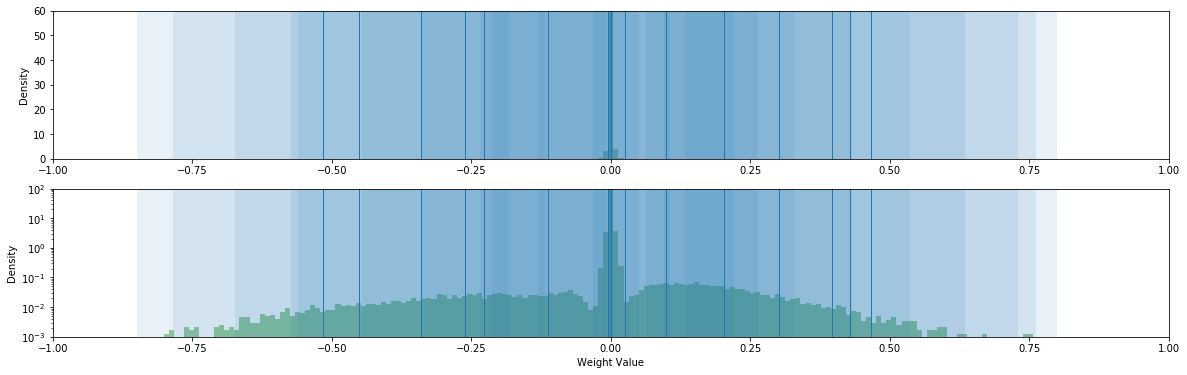

Temp: 2 Tau: 1e-07
Retrain Test: 97.76, Retrain Validation: 97.66, Prune Test: 91.93, Prune Validation: 91.63, Prune Sparsity: 93.70
Retrain Test: 96.87, Retrain Validation: 96.95, Prune Test: 96.32, Prune Validation: 96.18, Prune Sparsity: 97.53
Retrain Test: 97.06, Retrain Validation: 96.98, Prune Test: 96.26, Prune Validation: 96.02, Prune Sparsity: 97.18




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.95
Epoch: 20. Test Accuracy: 97.89
Epoch: 30. Test Accuracy: 97.81
Epoch: 40. Test Accuracy: 97.79
Epoch: 50. Test Accuracy: 97.82
Retrain Test: 97.82, Retrain Validation: 97.99, Prune Test: 97.69, Prune Validation: 97.77, Prune Sparsity: 62.07


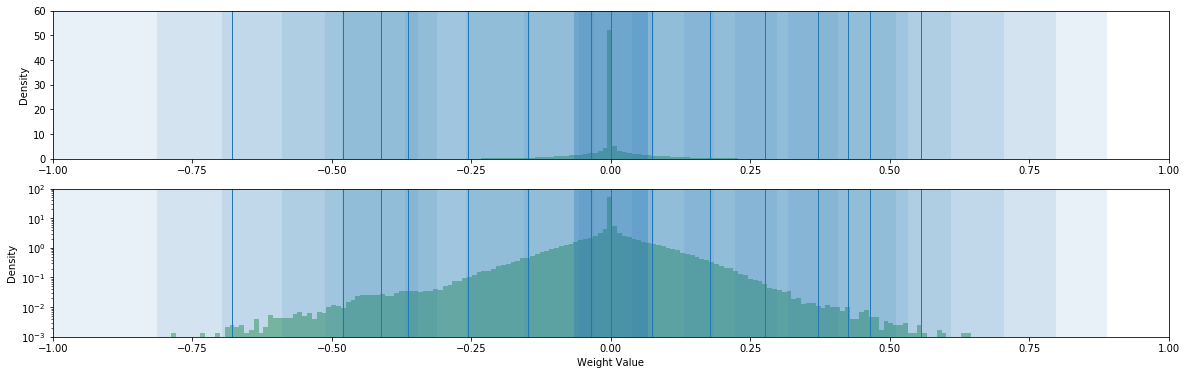

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.88
Epoch: 20. Test Accuracy: 97.88
Epoch: 30. Test Accuracy: 97.87
Epoch: 40. Test Accuracy: 97.88
Epoch: 50. Test Accuracy: 97.89
Retrain Test: 97.89, Retrain Validation: 97.93, Prune Test: 97.69, Prune Validation: 97.74, Prune Sparsity: 69.68


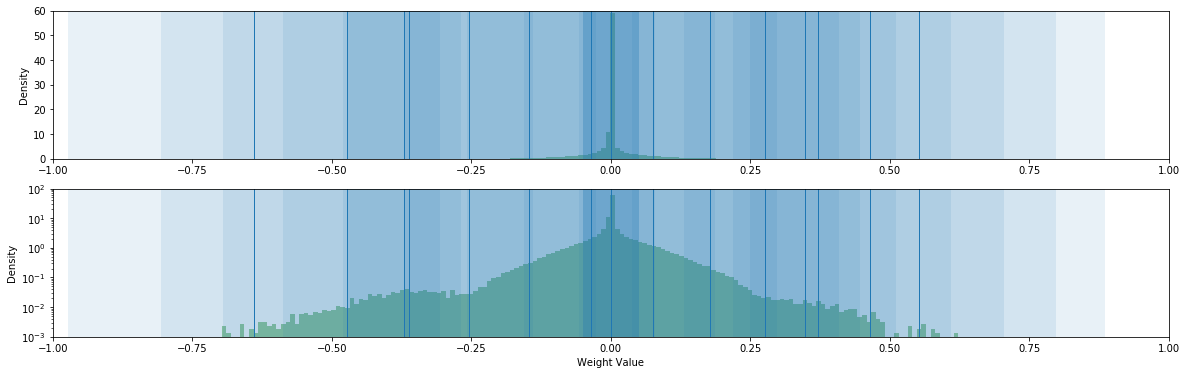

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.05
Epoch: 20. Test Accuracy: 98.02
Epoch: 30. Test Accuracy: 97.93
Epoch: 40. Test Accuracy: 97.95
Epoch: 50. Test Accuracy: 98.05
Retrain Test: 98.05, Retrain Validation: 98.04, Prune Test: 97.00, Prune Validation: 97.18, Prune Sparsity: 81.82


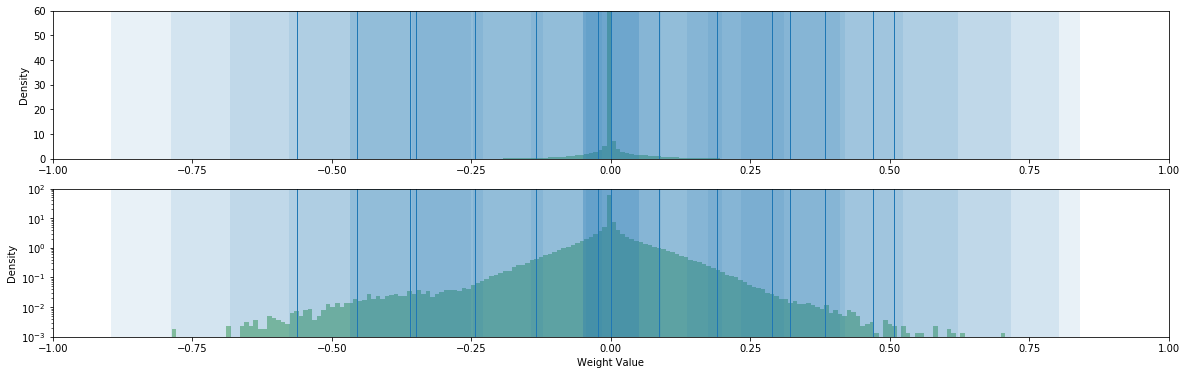

Temp: 2 Tau: 1e-08
Retrain Test: 97.82, Retrain Validation: 97.99, Prune Test: 97.69, Prune Validation: 97.77, Prune Sparsity: 62.07
Retrain Test: 97.89, Retrain Validation: 97.93, Prune Test: 97.69, Prune Validation: 97.74, Prune Sparsity: 69.68
Retrain Test: 98.05, Retrain Validation: 98.04, Prune Test: 97.00, Prune Validation: 97.18, Prune Sparsity: 81.82




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.03
Epoch: 20. Test Accuracy: 97.63
Epoch: 30. Test Accuracy: 96.32
Epoch: 40. Test Accuracy: 95.95
Epoch: 50. Test Accuracy: 95.84
Retrain Test: 95.84, Retrain Validation: 96.01, Prune Test: 92.41, Prune Validation: 92.45, Prune Sparsity: 98.93


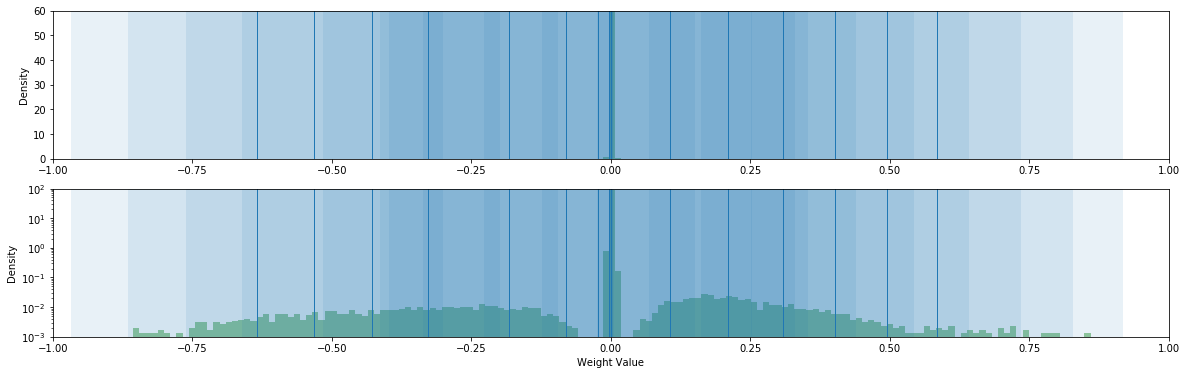

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.91
Epoch: 20. Test Accuracy: 97.71
Epoch: 30. Test Accuracy: 97.00
Epoch: 40. Test Accuracy: 96.57
Epoch: 50. Test Accuracy: 96.57
Retrain Test: 96.57, Retrain Validation: 96.36, Prune Test: 95.07, Prune Validation: 94.82, Prune Sparsity: 98.36


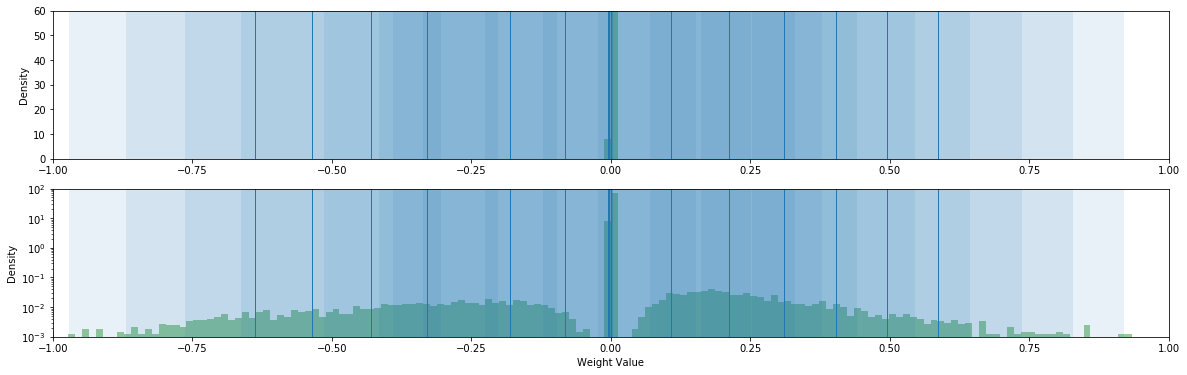

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.99
Epoch: 20. Test Accuracy: 97.62
Epoch: 30. Test Accuracy: 97.02
Epoch: 40. Test Accuracy: 96.60
Epoch: 50. Test Accuracy: 96.56
Retrain Test: 96.56, Retrain Validation: 96.29, Prune Test: 94.36, Prune Validation: 94.25, Prune Sparsity: 98.46


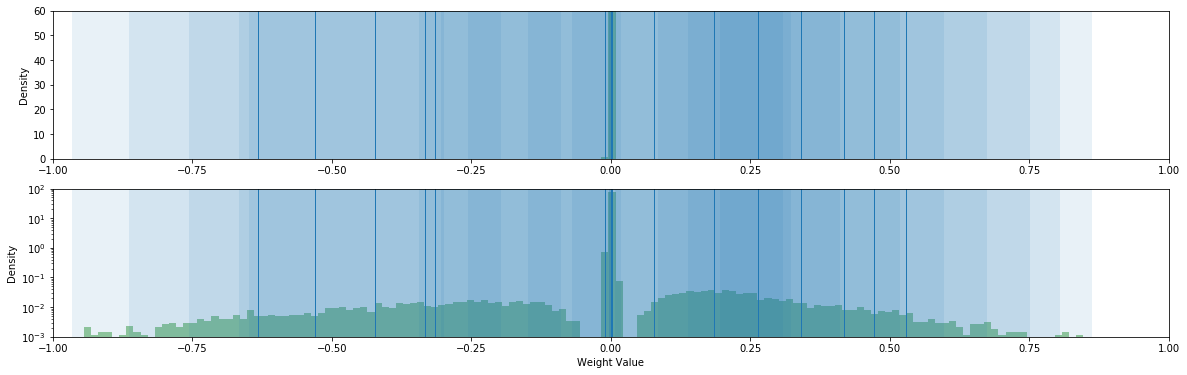

Temp: 4 Tau: 1e-06
Retrain Test: 95.84, Retrain Validation: 96.01, Prune Test: 92.41, Prune Validation: 92.45, Prune Sparsity: 98.93
Retrain Test: 96.57, Retrain Validation: 96.36, Prune Test: 95.07, Prune Validation: 94.82, Prune Sparsity: 98.36
Retrain Test: 96.56, Retrain Validation: 96.29, Prune Test: 94.36, Prune Validation: 94.25, Prune Sparsity: 98.46




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.96
Epoch: 20. Test Accuracy: 97.89
Epoch: 30. Test Accuracy: 98.07
Epoch: 40. Test Accuracy: 97.13
Epoch: 50. Test Accuracy: 97.45
Retrain Test: 97.45, Retrain Validation: 97.26, Prune Test: 92.86, Prune Validation: 92.36, Prune Sparsity: 94.55


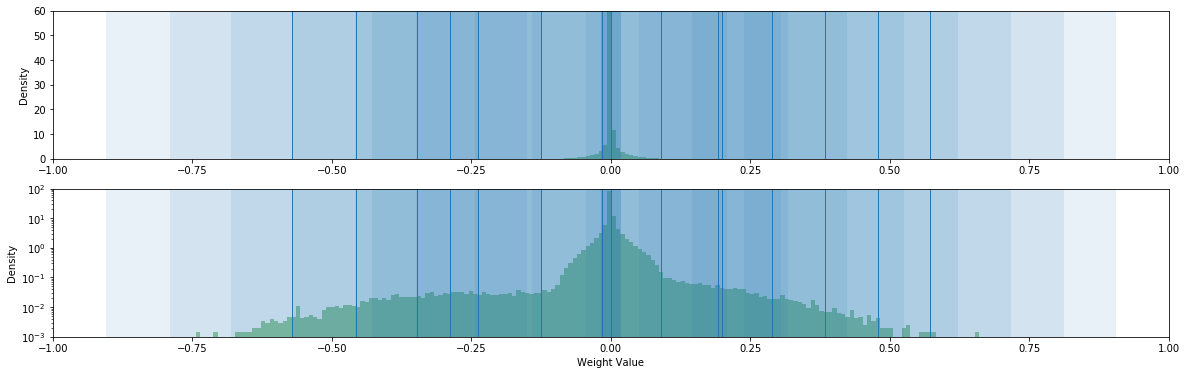

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.68
Epoch: 20. Test Accuracy: 98.09
Epoch: 30. Test Accuracy: 97.74
Epoch: 40. Test Accuracy: 98.06
Epoch: 50. Test Accuracy: 97.92
Retrain Test: 97.92, Retrain Validation: 97.80, Prune Test: 96.74, Prune Validation: 96.69, Prune Sparsity: 90.74


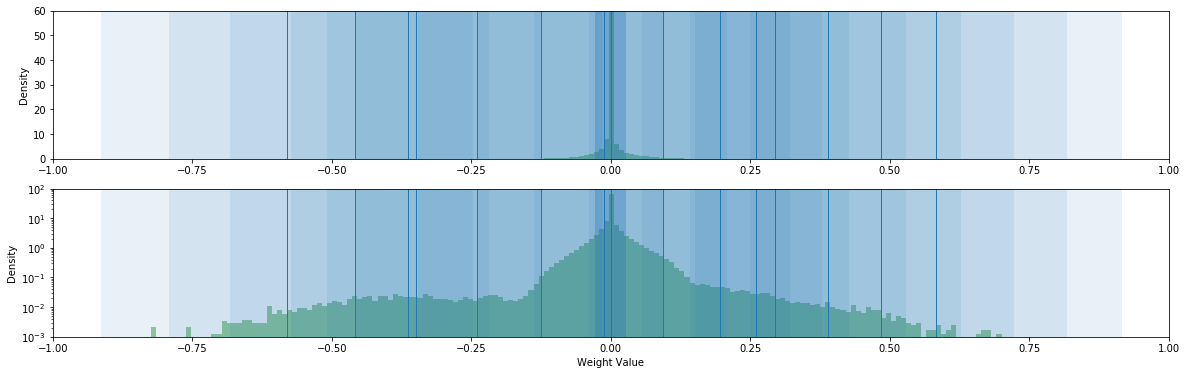

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.12
Epoch: 20. Test Accuracy: 98.09
Epoch: 30. Test Accuracy: 97.95
Epoch: 40. Test Accuracy: 97.90
Epoch: 50. Test Accuracy: 97.94
Retrain Test: 97.94, Retrain Validation: 97.85, Prune Test: 97.27, Prune Validation: 97.39, Prune Sparsity: 89.66


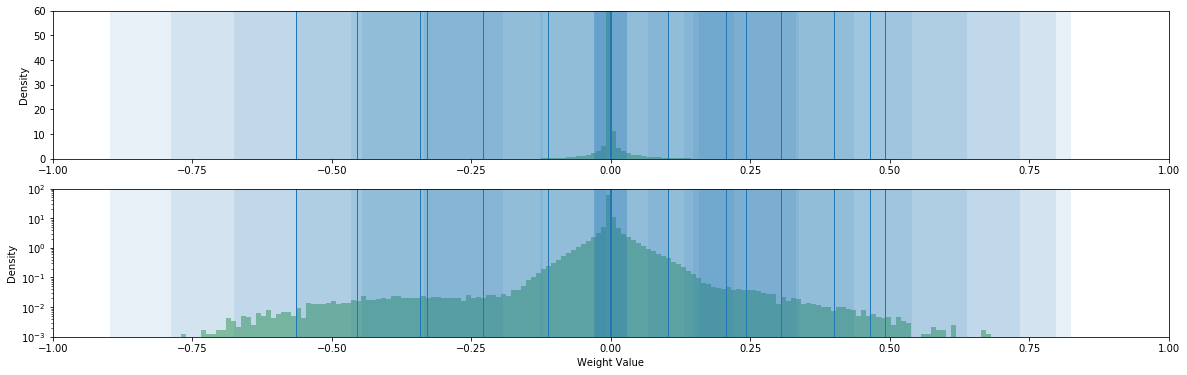

Temp: 4 Tau: 1e-07
Retrain Test: 97.45, Retrain Validation: 97.26, Prune Test: 92.86, Prune Validation: 92.36, Prune Sparsity: 94.55
Retrain Test: 97.92, Retrain Validation: 97.80, Prune Test: 96.74, Prune Validation: 96.69, Prune Sparsity: 90.74
Retrain Test: 97.94, Retrain Validation: 97.85, Prune Test: 97.27, Prune Validation: 97.39, Prune Sparsity: 89.66




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.06
Epoch: 20. Test Accuracy: 96.45
Epoch: 30. Test Accuracy: 97.99
Epoch: 40. Test Accuracy: 98.05
Epoch: 50. Test Accuracy: 98.08
Retrain Test: 98.08, Retrain Validation: 98.01, Prune Test: 97.81, Prune Validation: 97.83, Prune Sparsity: 62.06


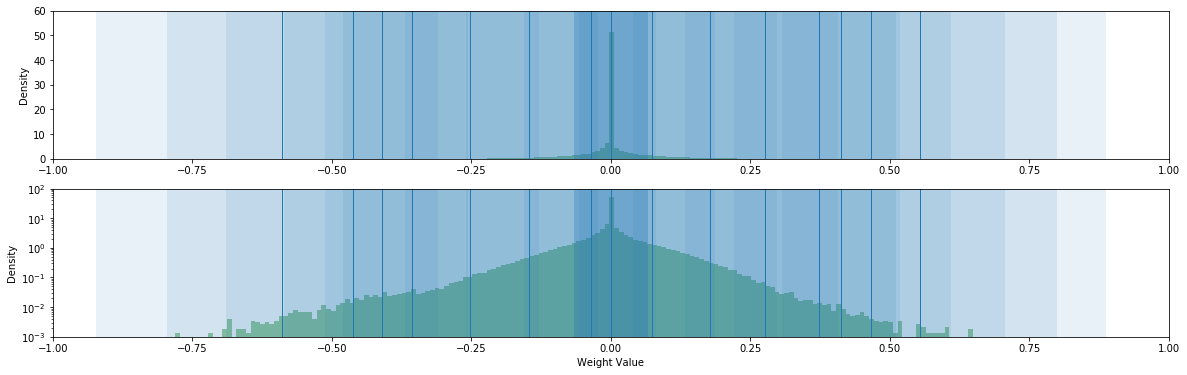

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.19
Epoch: 20. Test Accuracy: 98.19
Epoch: 30. Test Accuracy: 98.15
Epoch: 40. Test Accuracy: 98.04
Epoch: 50. Test Accuracy: 98.24
Retrain Test: 98.24, Retrain Validation: 98.20, Prune Test: 98.03, Prune Validation: 98.00, Prune Sparsity: 59.59


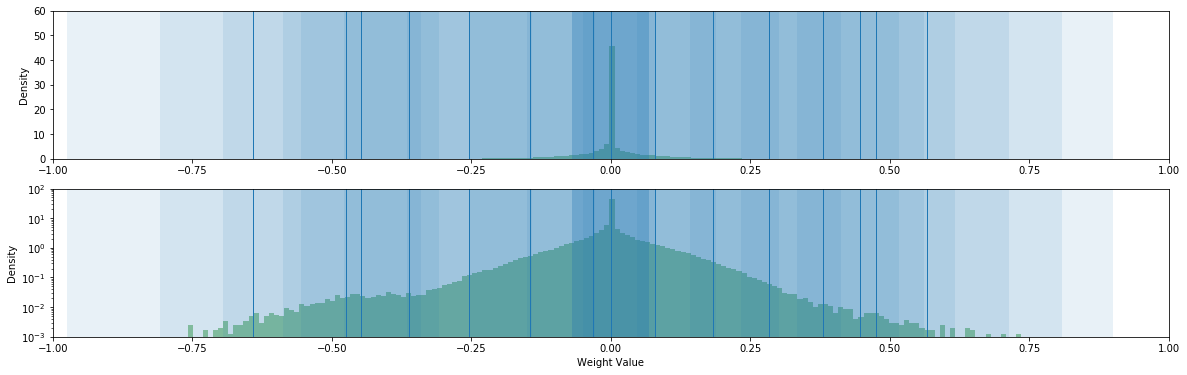

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.19
Epoch: 20. Test Accuracy: 97.48
Epoch: 30. Test Accuracy: 98.23
Epoch: 40. Test Accuracy: 98.22
Epoch: 50. Test Accuracy: 98.26
Retrain Test: 98.26, Retrain Validation: 98.25, Prune Test: 97.57, Prune Validation: 97.67, Prune Sparsity: 74.15


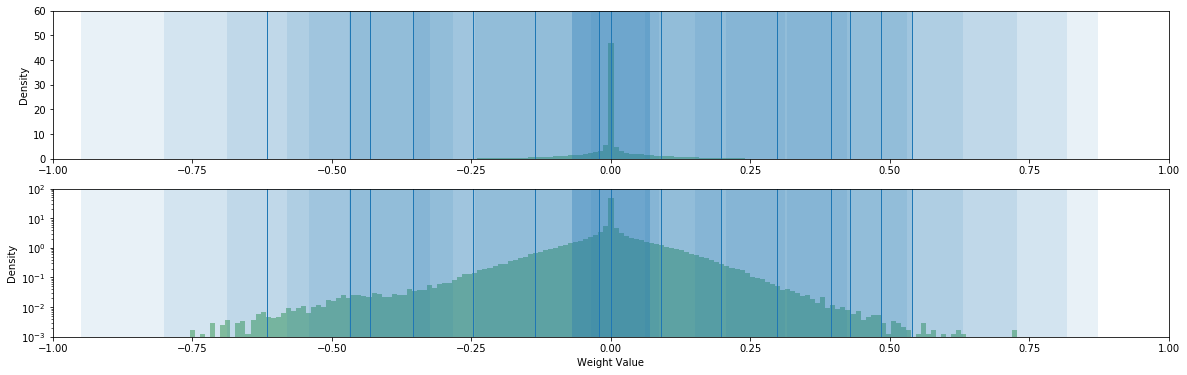

Temp: 4 Tau: 1e-08
Retrain Test: 98.08, Retrain Validation: 98.01, Prune Test: 97.81, Prune Validation: 97.83, Prune Sparsity: 62.06
Retrain Test: 98.24, Retrain Validation: 98.20, Prune Test: 98.03, Prune Validation: 98.00, Prune Sparsity: 59.59
Retrain Test: 98.26, Retrain Validation: 98.25, Prune Test: 97.57, Prune Validation: 97.67, Prune Sparsity: 74.15




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.68
Epoch: 20. Test Accuracy: 97.40
Epoch: 30. Test Accuracy: 96.86
Epoch: 40. Test Accuracy: 95.97
Epoch: 50. Test Accuracy: 95.83
Retrain Test: 95.83, Retrain Validation: 95.78, Prune Test: 91.66, Prune Validation: 92.01, Prune Sparsity: 98.91


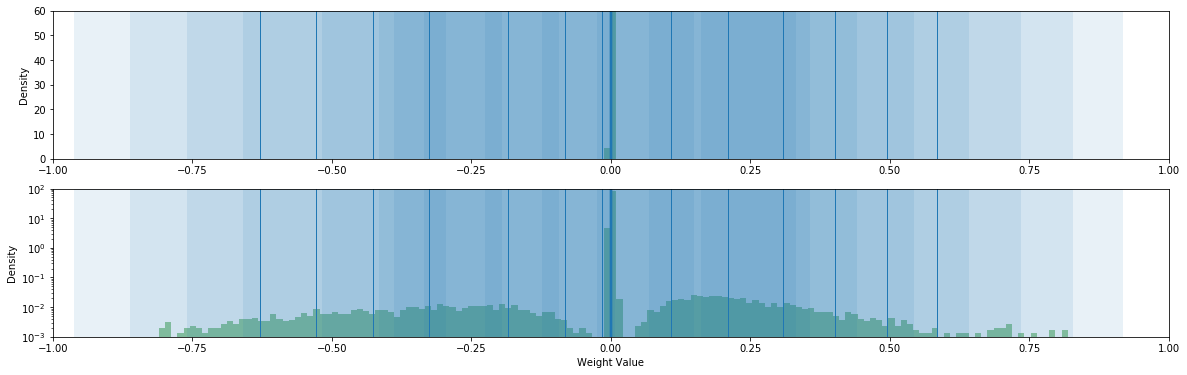

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.35
Epoch: 20. Test Accuracy: 98.22
Epoch: 30. Test Accuracy: 98.00
Epoch: 40. Test Accuracy: 97.76
Epoch: 50. Test Accuracy: 97.64
Retrain Test: 97.64, Retrain Validation: 97.18, Prune Test: 96.87, Prune Validation: 96.48, Prune Sparsity: 97.28


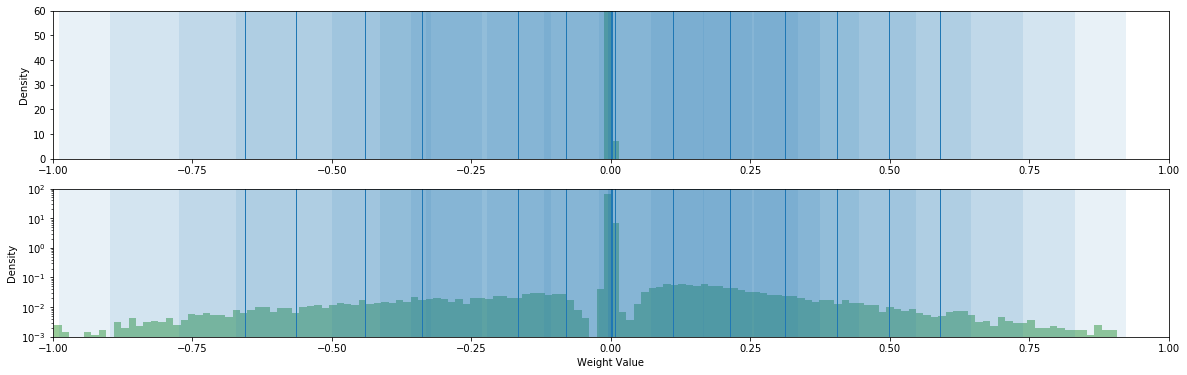

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.29
Epoch: 20. Test Accuracy: 98.08
Epoch: 30. Test Accuracy: 98.04
Epoch: 40. Test Accuracy: 97.81
Epoch: 50. Test Accuracy: 97.50
Retrain Test: 97.50, Retrain Validation: 97.51, Prune Test: 96.37, Prune Validation: 96.10, Prune Sparsity: 97.30


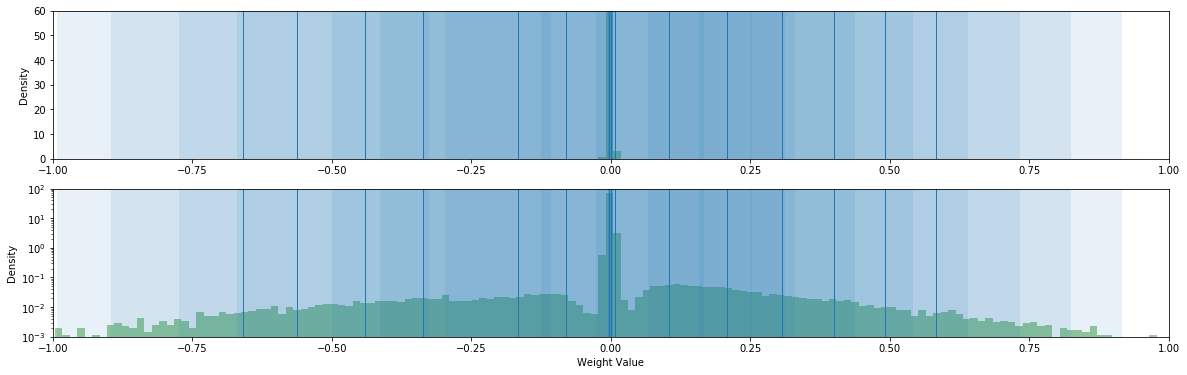

Temp: 10 Tau: 1e-06
Retrain Test: 95.83, Retrain Validation: 95.78, Prune Test: 91.66, Prune Validation: 92.01, Prune Sparsity: 98.91
Retrain Test: 97.64, Retrain Validation: 97.18, Prune Test: 96.87, Prune Validation: 96.48, Prune Sparsity: 97.28
Retrain Test: 97.50, Retrain Validation: 97.51, Prune Test: 96.37, Prune Validation: 96.10, Prune Sparsity: 97.30




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.79
Epoch: 20. Test Accuracy: 98.03
Epoch: 30. Test Accuracy: 97.95
Epoch: 40. Test Accuracy: 97.91
Epoch: 50. Test Accuracy: 97.54
Retrain Test: 97.54, Retrain Validation: 97.53, Prune Test: 94.05, Prune Validation: 94.17, Prune Sparsity: 94.78


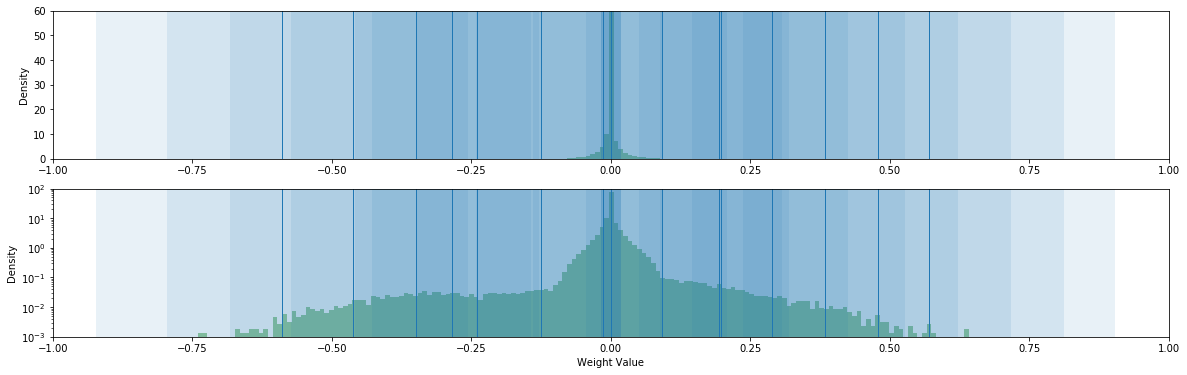

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.24
Epoch: 20. Test Accuracy: 98.32
Epoch: 30. Test Accuracy: 98.29
Epoch: 40. Test Accuracy: 98.25
Epoch: 50. Test Accuracy: 98.26
Retrain Test: 98.26, Retrain Validation: 98.22, Prune Test: 97.99, Prune Validation: 98.00, Prune Sparsity: 76.79


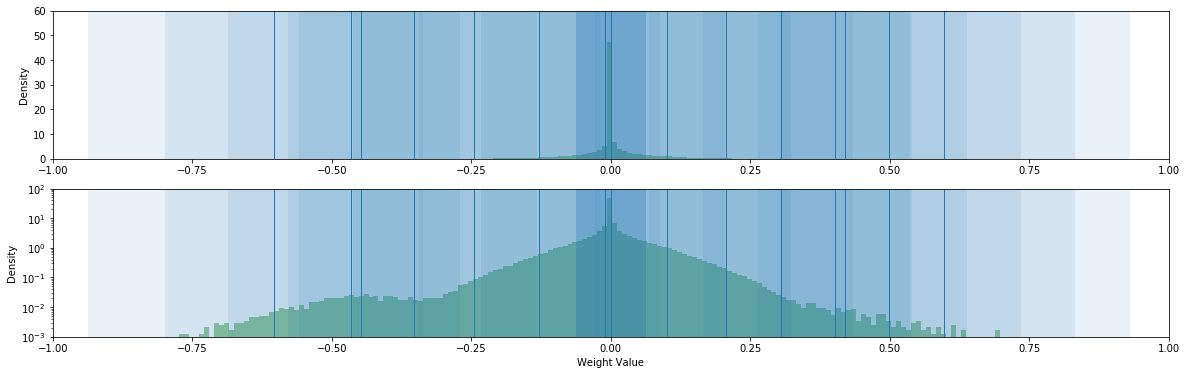

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.22
Epoch: 20. Test Accuracy: 98.27
Epoch: 30. Test Accuracy: 98.22
Epoch: 40. Test Accuracy: 98.29
Epoch: 50. Test Accuracy: 98.22
Retrain Test: 98.22, Retrain Validation: 98.28, Prune Test: 97.88, Prune Validation: 97.73, Prune Sparsity: 79.07


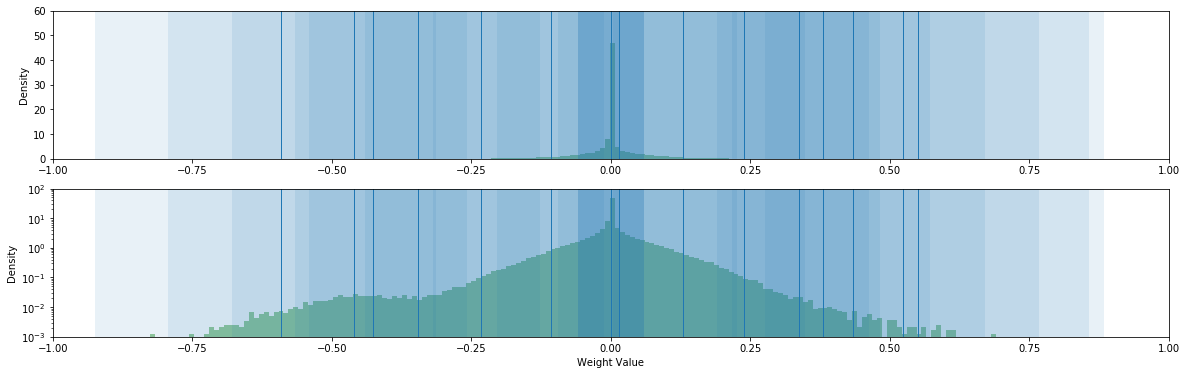

Temp: 10 Tau: 1e-07
Retrain Test: 97.54, Retrain Validation: 97.53, Prune Test: 94.05, Prune Validation: 94.17, Prune Sparsity: 94.78
Retrain Test: 98.26, Retrain Validation: 98.22, Prune Test: 97.99, Prune Validation: 98.00, Prune Sparsity: 76.79
Retrain Test: 98.22, Retrain Validation: 98.28, Prune Test: 97.88, Prune Validation: 97.73, Prune Sparsity: 79.07




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.95
Epoch: 20. Test Accuracy: 97.91
Epoch: 30. Test Accuracy: 97.95
Epoch: 40. Test Accuracy: 97.95
Epoch: 50. Test Accuracy: 98.00
Retrain Test: 98.00, Retrain Validation: 97.87, Prune Test: 97.54, Prune Validation: 97.57, Prune Sparsity: 63.69


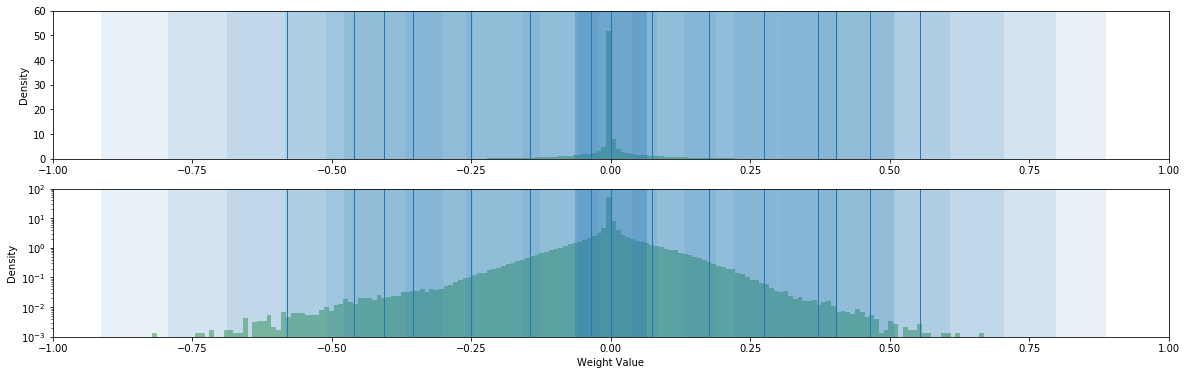

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.19
Epoch: 20. Test Accuracy: 98.22
Epoch: 30. Test Accuracy: 98.22
Epoch: 40. Test Accuracy: 98.18
Epoch: 50. Test Accuracy: 98.18
Retrain Test: 98.18, Retrain Validation: 98.12, Prune Test: 98.04, Prune Validation: 97.95, Prune Sparsity: 47.88


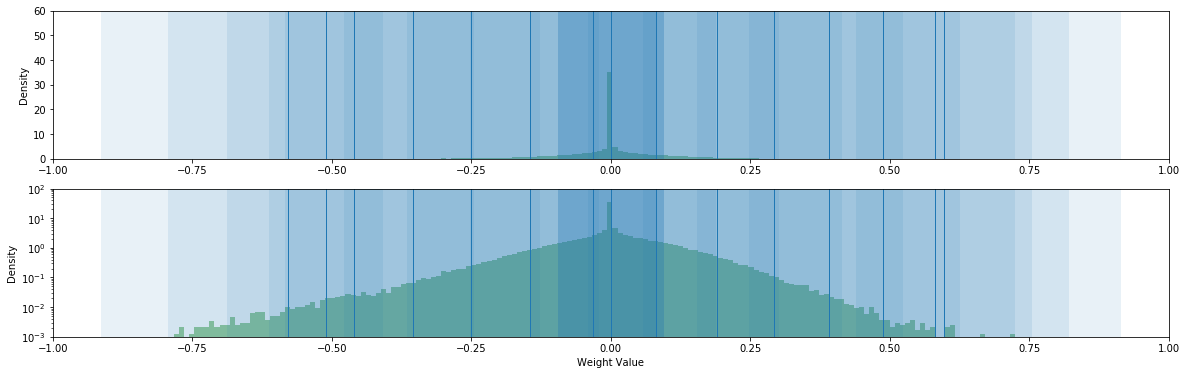

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.25
Epoch: 20. Test Accuracy: 98.25
Epoch: 30. Test Accuracy: 98.17
Epoch: 40. Test Accuracy: 98.29
Epoch: 50. Test Accuracy: 98.22
Retrain Test: 98.22, Retrain Validation: 98.17, Prune Test: 97.97, Prune Validation: 98.00, Prune Sparsity: 49.16


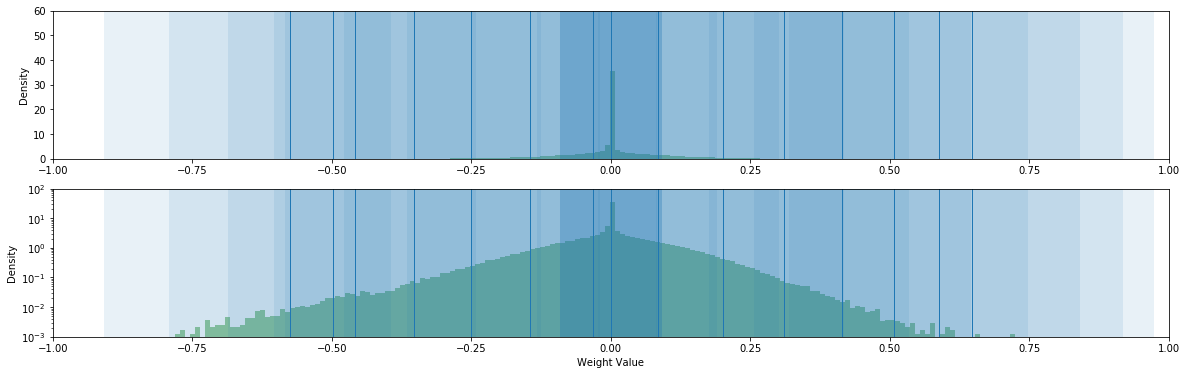

Temp: 10 Tau: 1e-08
Retrain Test: 98.00, Retrain Validation: 97.87, Prune Test: 97.54, Prune Validation: 97.57, Prune Sparsity: 63.69
Retrain Test: 98.18, Retrain Validation: 98.12, Prune Test: 98.04, Prune Validation: 97.95, Prune Sparsity: 47.88
Retrain Test: 98.22, Retrain Validation: 98.17, Prune Test: 97.97, Prune Validation: 98.00, Prune Sparsity: 49.16




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.59
Epoch: 20. Test Accuracy: 97.61
Epoch: 30. Test Accuracy: 96.57
Epoch: 40. Test Accuracy: 96.01
Epoch: 50. Test Accuracy: 95.90
Retrain Test: 95.90, Retrain Validation: 95.92, Prune Test: 92.97, Prune Validation: 92.78, Prune Sparsity: 98.90


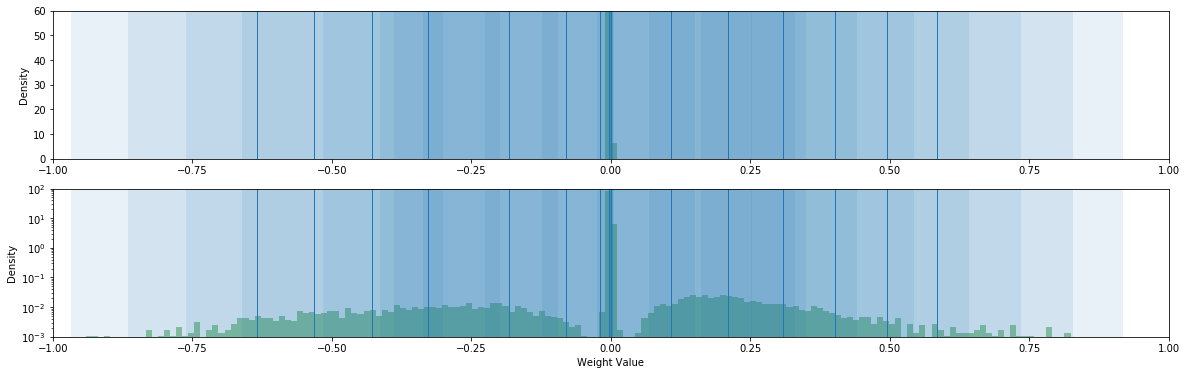

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.21
Epoch: 20. Test Accuracy: 98.24
Epoch: 30. Test Accuracy: 98.14
Epoch: 40. Test Accuracy: 98.15
Epoch: 50. Test Accuracy: 98.08
Retrain Test: 98.08, Retrain Validation: 98.08, Prune Test: 95.73, Prune Validation: 95.79, Prune Sparsity: 94.10


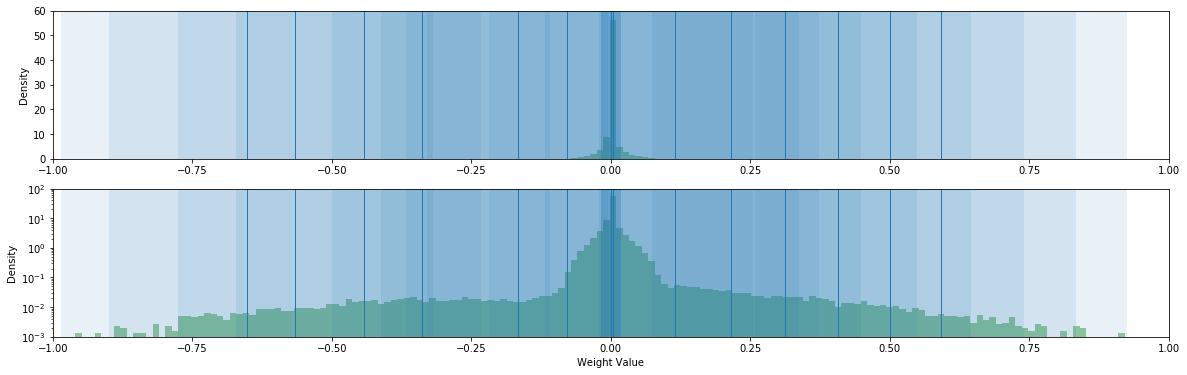

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.25
Epoch: 20. Test Accuracy: 98.22
Epoch: 30. Test Accuracy: 98.13
Epoch: 40. Test Accuracy: 98.15
Epoch: 50. Test Accuracy: 98.10
Retrain Test: 98.10, Retrain Validation: 98.07, Prune Test: 97.17, Prune Validation: 97.27, Prune Sparsity: 93.32


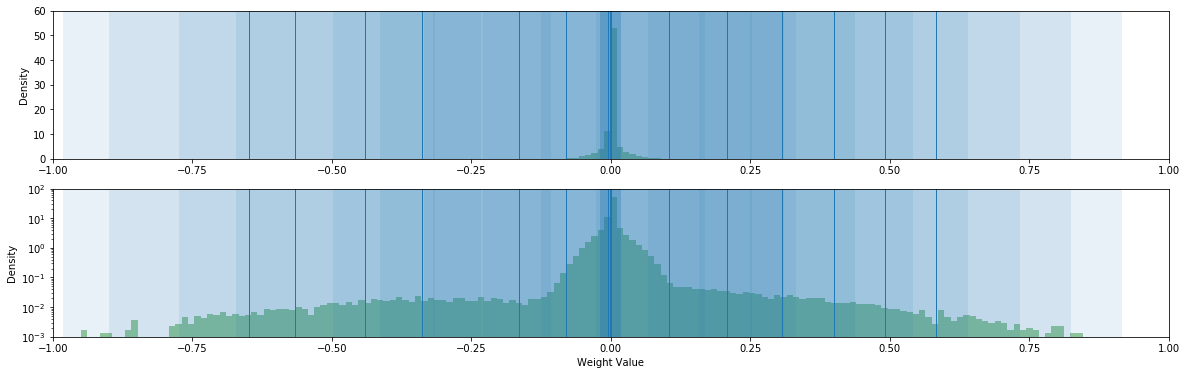

Temp: 20 Tau: 1e-06
Retrain Test: 95.90, Retrain Validation: 95.92, Prune Test: 92.97, Prune Validation: 92.78, Prune Sparsity: 98.90
Retrain Test: 98.08, Retrain Validation: 98.08, Prune Test: 95.73, Prune Validation: 95.79, Prune Sparsity: 94.10
Retrain Test: 98.10, Retrain Validation: 98.07, Prune Test: 97.17, Prune Validation: 97.27, Prune Sparsity: 93.32




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.05
Epoch: 20. Test Accuracy: 98.12
Epoch: 30. Test Accuracy: 97.93
Epoch: 40. Test Accuracy: 97.85
Epoch: 50. Test Accuracy: 97.82
Retrain Test: 97.82, Retrain Validation: 97.82, Prune Test: 93.85, Prune Validation: 93.42, Prune Sparsity: 94.12


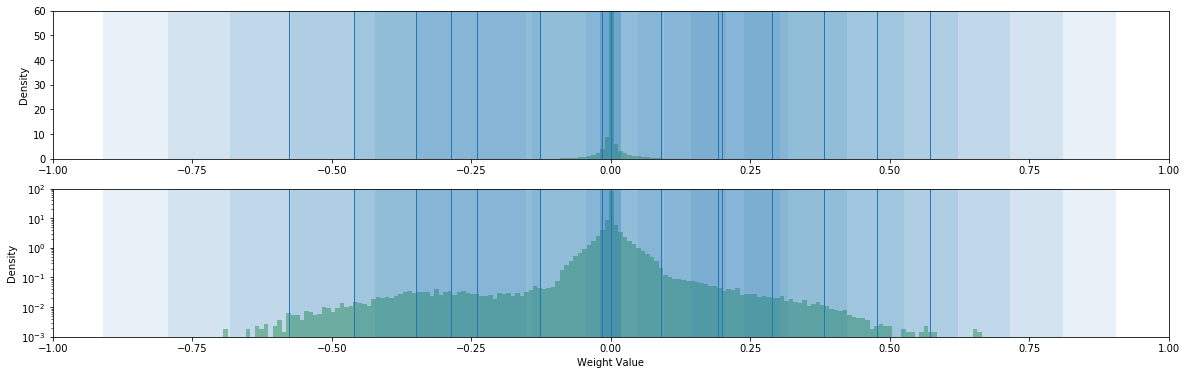

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.25
Epoch: 20. Test Accuracy: 98.28
Epoch: 30. Test Accuracy: 98.28
Epoch: 40. Test Accuracy: 98.23
Epoch: 50. Test Accuracy: 98.25
Retrain Test: 98.25, Retrain Validation: 98.24, Prune Test: 98.04, Prune Validation: 97.97, Prune Sparsity: 71.92


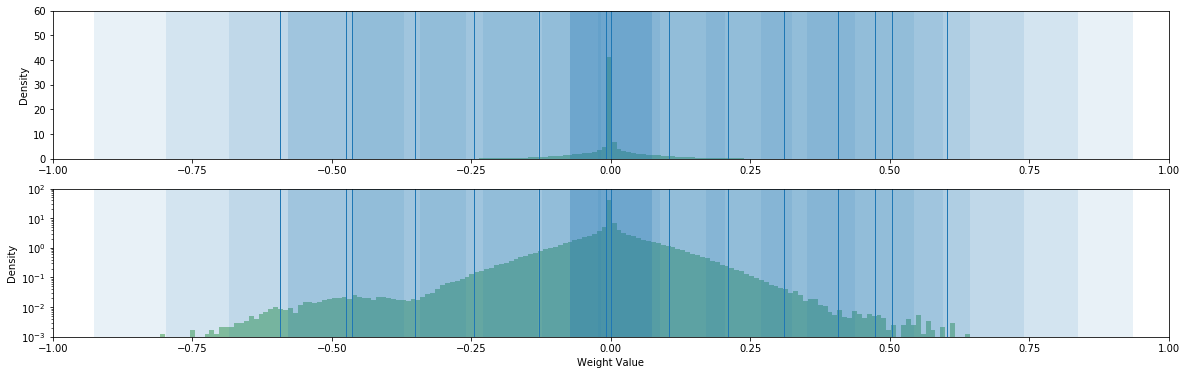

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.23
Epoch: 20. Test Accuracy: 98.26
Epoch: 30. Test Accuracy: 98.25
Epoch: 40. Test Accuracy: 98.25
Epoch: 50. Test Accuracy: 98.26
Retrain Test: 98.26, Retrain Validation: 98.20, Prune Test: 97.21, Prune Validation: 96.95, Prune Sparsity: 75.83


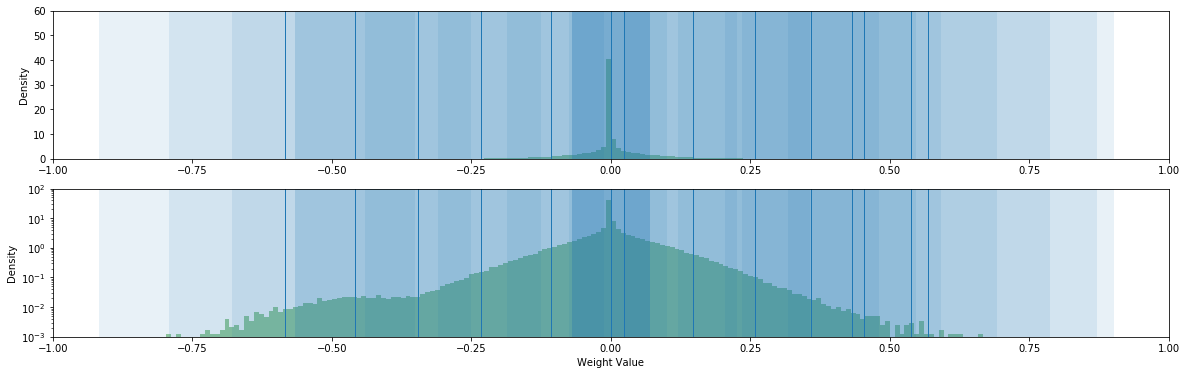

Temp: 20 Tau: 1e-07
Retrain Test: 97.82, Retrain Validation: 97.82, Prune Test: 93.85, Prune Validation: 93.42, Prune Sparsity: 94.12
Retrain Test: 98.25, Retrain Validation: 98.24, Prune Test: 98.04, Prune Validation: 97.97, Prune Sparsity: 71.92
Retrain Test: 98.26, Retrain Validation: 98.20, Prune Test: 97.21, Prune Validation: 96.95, Prune Sparsity: 75.83




**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.04
Epoch: 20. Test Accuracy: 98.07
Epoch: 30. Test Accuracy: 98.04
Epoch: 40. Test Accuracy: 98.00
Epoch: 50. Test Accuracy: 97.96
Retrain Test: 97.96, Retrain Validation: 98.05, Prune Test: 97.77, Prune Validation: 97.72, Prune Sparsity: 65.09


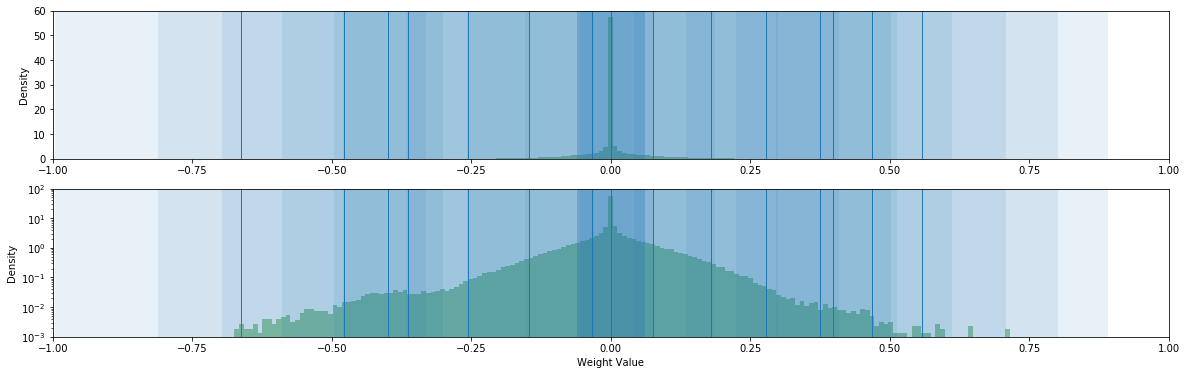

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.22
Epoch: 20. Test Accuracy: 98.22
Epoch: 30. Test Accuracy: 98.22
Epoch: 40. Test Accuracy: 98.21
Epoch: 50. Test Accuracy: 98.26
Retrain Test: 98.26, Retrain Validation: 98.19, Prune Test: 98.07, Prune Validation: 97.91, Prune Sparsity: 44.51


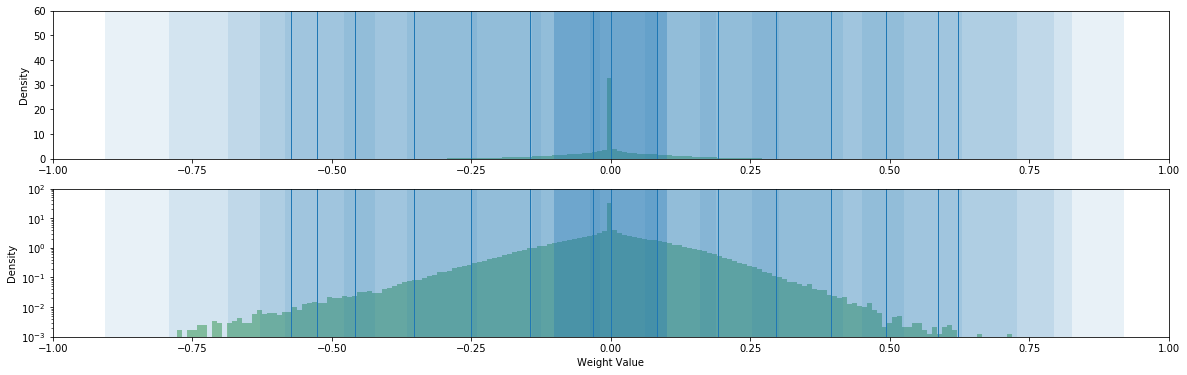

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.26
Epoch: 20. Test Accuracy: 98.18
Epoch: 30. Test Accuracy: 98.23
Epoch: 40. Test Accuracy: 98.23
Epoch: 50. Test Accuracy: 98.21
Retrain Test: 98.21, Retrain Validation: 98.20, Prune Test: 97.93, Prune Validation: 98.07, Prune Sparsity: 44.36


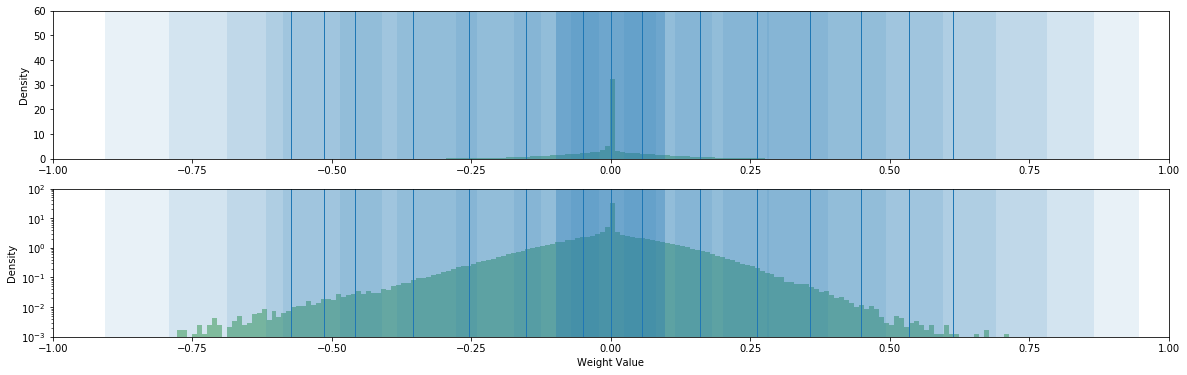

Temp: 20 Tau: 1e-08
Retrain Test: 97.96, Retrain Validation: 98.05, Prune Test: 97.77, Prune Validation: 97.72, Prune Sparsity: 65.09
Retrain Test: 98.26, Retrain Validation: 98.19, Prune Test: 98.07, Prune Validation: 97.91, Prune Sparsity: 44.51
Retrain Test: 98.21, Retrain Validation: 98.20, Prune Test: 97.93, Prune Validation: 98.07, Prune Sparsity: 44.36


Temp: 1 Tau: 1e-06
Retrain Test: 95.90, Retrain Validation: 95.81, Prune Test: 91.75, Prune Validation: 91.90, Prune Sparsity: 98.94
Retrain Test: 89.52, Retrain Validation: 89.58, Prune Test: 38.02, Prune Validation: 39.63, Prune Sparsity: 99.77
Retrain Test: 89.77, Retrain Validation: 90.49, Prune Test: 52.40, Prune Validation: 54.63, Prune Sparsity: 99.75

Temp: 1 Tau: 1e-07
Retrain Test: 97.64, Retrain Validation: 97.56, Prune Test: 91.25, Prune Validation: 90.93, Prune Sparsity: 94.26
Retrain Test: 96.28, Retrain Validation: 95.96, Prune Test: 92.46, Prune Validation: 92.69, Prune Sparsity: 98.78
Retrain Test: 96.24, Retrai

<IPython.core.display.Javascript object>

In [7]:
%%notify
res_str = ""
for temp in [1, 2, 4, 10, 20]:
    for tau in [1e-6, 1e-7, 1e-8]:
        _, _, _, _, _, _, res = all_exp(alpha, beta, tau, temp, mixtures, model_name)
        res_str = res_str + res
print (res_str)